# estimating uncertainty in mean death rate
Tim Tyree<br>
3.30.2021

In [2]:
from lib.my_initialization import *
import random,scipy
from scipy import stats

In [3]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A'] #[Hz?]/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A'] #[Hz?]/cm^2

In [4]:
#load osgdata
data_mc_fn='osg_output/run_1_merged.csv'
df=pd.read_csv(data_mc_fn)
df.drop(columns=['dt'],inplace=True)

__Schema for results__
- for each r,D,kappa,L triplet
    - TODO: compute mean w versus q
    - TODO: save as pandas data frame
    - TODO: bootstrap an uncertainty in this mean w
- TODO(later): find out where w versus q has all areas falling on the same axis

In [5]:
# the set of all inputs
r_values=np.array([0.1,0.2,0.3,0.4,0.5,1.0])#cm
D_values=np.array([0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0])#cm^2/s
A_values=np.array([20.25,25,39,50,56.25,100,156.25,189])[::-1]#cm^2
L_values=np.sqrt(A_values)#cm
kappa_values=np.array([1,10,100])#1/s
print(L_values)

[13.74772708 12.5        10.          7.5         7.07106781  6.244998
  5.          4.5       ]


In [6]:
#slice data for a given condition
r=0.1;D=1.5;L=10.;kappa=10;
query=(df.r==r)&(df.D==D)&(df.L==L)&(df.kappa==kappa)
dff=df[query].copy().drop(columns=['r','D','L','kappa'])
dff['11'].size

1500

In [7]:
#extract the values
dfd=dff.describe().T.drop(columns=['count'])
# y_values=dfd['50%'].values.copy()
# yerr1_values=dfd['25%'].values.copy()
# yerr2_values=dfd['75%'].values.copy()

y_values=dfd['mean'].values.copy()
# y2err1_values=y2_values-dfd['std'].values.copy()
# y2err2_values=y2_values+dfd['std'].values.copy()
dfd.reset_index(inplace=True,drop=True)
dfd['N']=dfd.index.values+11
x_values=dfd.N.values

In [8]:
def model(xs, k, m):
    return k * xs + m

def l2_loss(tup, xs, ys):
    k, m = tup
    delta = model(xs, k, m) - ys
    return np.dot(delta, delta)

In [9]:
# xs=x_values; x_scale=x_values
# ys=y_values; y_scale=y_values
# plt.scatter(xs, ys, alpha=0.5, s=100)
# xys = list(zip(xs, ys))
# curves = []
# for i in range(100):
#     # sample with replacement
#     bootstrap = [random.choice(xys) for _ in xys]
#     xs_bootstrap = np.array([x for x, y in bootstrap])
#     ys_bootstrap = np.array([y for x, y in bootstrap])
#     k_hat, m_hat = scipy.optimize.minimize(
#         l2_loss, (0, 0), args=(xs_bootstrap, ys_bootstrap)
#     ).x
#     curves.append(model(x_scale, k_hat, m_hat))

# # Plot individual lines
# for curve in curves:
#     plt.plot(x_scale, curve, alpha=0.1, linewidth=3, color='green')

# # Plot 95% confidence interval
# lo, hi = np.percentile(curves, (2.5, 97.5), axis=0)
# plt.fill_between(x_scale, lo, hi, color='red', alpha=0.5)
# # plt.ylabel('Weight of elephant (kg)')
# plt.show()

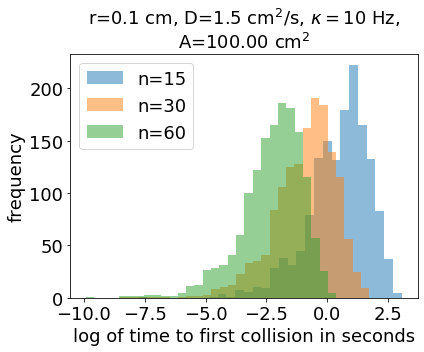

In [10]:
fontsize=18
figsize=(6,5)
saving=True
savefig_folder=f'{nb_dir}/data/osg_output/fig'
savefig_fn=f'stopping_times_log_r_{r}_D_{D}_k_{kappa}_A={L**2:.2f}.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]
ni_lst=[4,19,-10]
T_lst=[];n_lst=[]
for ni in ni_lst:
    col = dff.columns[ni]
    n=eval(col)
    T=dff[col].values
    n_lst.append(n)
    T_lst.append(T)
    plt.hist(np.log(T),bins=30,label=f"n={n}",alpha=0.5)
plt.legend(fontsize=fontsize)
plt.xlabel('log of time to first collision in seconds',fontsize=fontsize)
plt.ylabel('frequency',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.title(f'r={r} cm, D={D} '+r'cm$^{2}$/s, $\kappa=$'+f'{kappa} Hz,\nA={L**2:.2f} '+r"cm$^2$", fontsize=fontsize)
plt.tight_layout()
# plt.xscale('log')
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [11]:
len(list(set(T_lst[2])))
# len(T_lst[1])

1481

__Result__: This stopping time data is not significantly different from the fitted exponential distribution according to the Anderson-Darling test, the Cram\'er-von Mises test, the Kolmagorov-Smirnov test, the Kuiper test, the Pearson \[Chi]^2 test, and the Watson U^2 test (p>0.1).  This holds for a small number of particles (N=11) and for a large number of particles (N=69).  Here, we consider A=100cm^2, r = 0.1 cm, D = 1.5 cm^2/s, and \[Kappa]=10 Hz.

__Discussion__:  Let $T(N)\sim Exp[\bar{T}(N)]$ be the distribution of times for the reaction $N\rightarrow N-2$.

An emergent result is $T(N)\sim Exp[\bar{T}(N)]$, where $Exp[\mu]$ is the exponential distribution with mean value $\mu>0$.

The corresponding death rate follows the statisticical distribution, 
$$
W_{-2}(N)\sim 1/T(N)\sim Exp[-\bar{T}(N)]
$$

With normalized probability density function
$$
P(W_{-2}=W)=?? Nope
$$

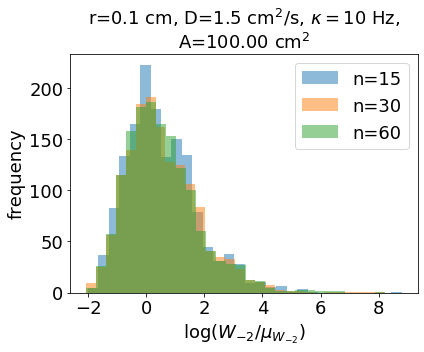

In [12]:
fontsize=18
figsize=(6,5)
saving=True
savefig_folder=f'{nb_dir}/data/osg_output/fig'
# savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'lograte_r_{r}_D_{D}_k_{kappa}_A={L**2:.2f}.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]
ni_lst=[4,19,-10]
T_lst=[]
for ni in ni_lst:
    col = dff.columns[ni]
    n=eval(col)
    T=dff[col].values
    T_lst.append(T)
    plt.hist(np.log(np.mean(T)/T),bins=30,label=f"n={n}",alpha=0.5)
plt.legend(fontsize=fontsize)
plt.xlabel(r'$\log(W_{-2}/\mu_{W_{-2}})$',fontsize=fontsize)
plt.ylabel('frequency',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.title(f'r={r} cm, D={D} '+r'cm$^{2}$/s, $\kappa=$'+f'{kappa} Hz,\nA={L**2:.2f} '+r"cm$^2$", fontsize=fontsize)
plt.tight_layout()
# plt.xscale('log')
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [13]:
np.sqrt(0.00070)

0.026457513110645904

## Validation of error estimation by bootstrap
Summary: we may approximate the variance of the mean death rate by
$$Var[\hat{\mu}_{W_{-2}}]\sim \mu_{W_{-2}} Var[Z'] = \mu_{W_{-2}}*0.00070(7)$$

Suggesting 95% confidence interval, 

$$
E[W_{-2}]  = \mu_{W_{-2}}^\text{apparent} \cdot( 1 \pm 0.05 )  
$$

Or a constant 5% relative uncertainty in mean death rate.

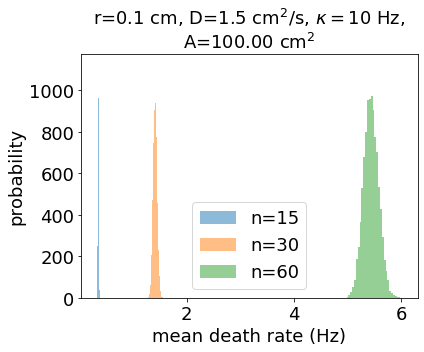

In [14]:
fontsize=18
figsize=(6,5)
saving=True
# savefig_folder=f'{nb_dir}/../fig'
savefig_folder=f'{nb_dir}/data/osg_output/fig'
savefig_fn=f'rate_bootstrap_r_{r}_D_{D}_k_{kappa}_A={L**2:.2f}.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]
mu_lst=[];sig_lst=[]
bootstrap_raw_lst=[]
for n,T in zip(n_lst,T_lst):
    mean_lst = []
    for i in range(10000):
        # sample with replacement
        T_bootstrap = [random.choice(T) for _ in T]
        mean=1/np.mean(T_bootstrap)#np.log(np.mean(T)/T)
        mean_lst.append(mean)
    # Plot histogram of mean values
    plt.hist(mean_lst,bins=30,label=f"n={n}",alpha=0.5)
    bootstrap_raw_lst.append(mean_lst)
    mu=np.mean(mean_lst)
    sig=np.std(mean_lst)
    mu_lst.append(mu)
    sig_lst.append(sig)

plt.legend(fontsize=fontsize)
plt.xlabel(r'mean death rate (Hz)',fontsize=fontsize)
plt.ylabel('probability',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.title(f'r={r} cm, D={D} '+r'cm$^{2}$/s, $\kappa=$'+f'{kappa} Hz,\nA={L**2:.2f} '+r"cm$^2$", fontsize=fontsize)
plt.tight_layout()
# plt.xscale('log')
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [15]:
print(mu_lst)
print(sig_lst)

[0.3511649799446669, 1.4087691712837638, 5.435879216458365]
[0.00910892947270037, 0.03832900949109117, 0.14089336028053714]


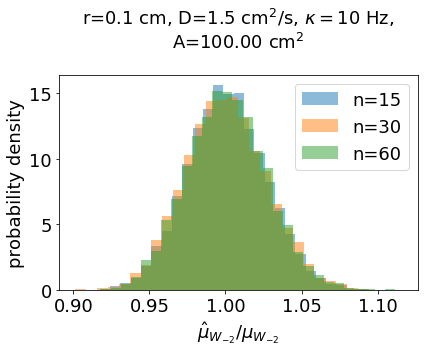

In [19]:
fontsize=18
figsize=(6,5)
saving=True
savefig_folder=f'{nb_dir}/../fig'
# savefig_folder=f'{nb_dir}/data/osg_output/fig'
# savefig_fn=f'rate_bootstrap_fractional_log_r_{r}_D_{D}_k_{kappa}_A={L**2:.2f}.png'
savefig_fn=f'Delta_rate_bootstrap_fractional_r_{r}_D_{D}_k_{kappa}_A={L**2:.2f}.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]
mu_lst=[];sig_lst=[]
bootstrap_lst=[]
for n,T in zip(n_lst,T_lst):
    mean_lst = []
    muT=np.mean(T)
    for i in range(10000):
        # sample with replacement
        T_bootstrap = [random.choice(T) for _ in T]
#         mean=np.log(muT/np.mean(T_bootstrap))
        mean=muT/np.mean(T_bootstrap)
        mean_lst.append(mean)
    # Plot histogram of mean values
    plt.hist(mean_lst,bins=30,label=f"n={n}",alpha=0.5, density=True)
    bootstrap_lst.append(mean_lst)
    mu=np.mean(mean_lst)
    sig=np.std(mean_lst)
    mu_lst.append(mu)
    sig_lst.append(sig)

plt.legend(fontsize=fontsize)
plt.xlabel(r'$\hat{\mu}_{W_{-2}}/\mu_{W_{-2}}$',fontsize=fontsize)
# plt.xlabel(r'$\log(\hat{\mu}_{W_{-2}}/\mu_{W_{-2}})$ (Hz)',fontsize=fontsize)
plt.ylabel('probability density',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.title(f'r={r} cm, D={D} '+r'cm$^{2}$/s, $\kappa=$'+f'{kappa} Hz,\nA={L**2:.2f} '+r"cm$^2$"+f"\n", fontsize=fontsize)
plt.tight_layout()
# plt.xscale('log')
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [20]:
print(mu_lst)
print(sig_lst)

[1.0007771106494356, 1.0002994431109717, 1.001003632324941]
[0.02571452488414802, 0.02691875757311061, 0.026296333557246705]


In [23]:
np.mean(1.96*np.array(sig_lst))

0.051567349129476824

In [17]:
stats.normaltest?

In [110]:
print(np.mean((0.025444680157234202, 0.026843710145676505, 0.026202725287278232)))

0.026163705196729645


In [131]:
for n,bootstrap in zip(n_lst,bootstrap_lst):
#     _,p=stats.shapiro(bootstrap)
    _, p = stats.normaltest(bootstrap)
    print(f"n={n},p={p:g}")
    alpha = 0.05
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("\tThe null hypothesis can be rejected.  The data is significantly different from the normal distribution.")
    else:
        print("\tThe null hypothesis cannot be rejected.  The data is not significantly different from the normal distribution.")

n=15,p=0.366682
p = 0.366682
	The null hypothesis cannot be rejected.  The data is not significantly different from the normal distribution.
n=30,p=0.428214
p = 0.428214
	The null hypothesis cannot be rejected.  The data is not significantly different from the normal distribution.
n=60,p=0.0759896
p = 0.0759896
	The null hypothesis cannot be rejected.  The data is not significantly different from the normal distribution.


In [128]:
from scipy import stats
pts = 1000
np.random.seed(28041990)
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(0, 1, size=pts)
x = np.concatenate((a, b))
k2, p = stats.normaltest(x)
alpha = 1e-3
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.64408
The null hypothesis cannot be rejected


me

__Results:__  
- The quantity $Z = \log(\hat{\mu}_{W_{-2}}/\mu_{W_{-2}})$ is not significantly different from a normal distribution with mean 0 and a sample variance that is independent of the number of particles.
- The 95% CI for the $\sigma_Z^2$ is 0.00069 +- 0.00003
- Corollary:
    - $\hat{\mu}_{W_{-2}}\sim \mu_{W_{-2}} e^Z$


In [140]:
expvar=np.mean([sig**2 for sig in sig_lst])
errvar=np.std([sig**2 for sig in sig_lst])
print(r"the 95% CI for the $\sigma_Z^2$ is "+f"{expvar:.5f} +- {2*errvar:.5f}")

the 95% CI for the $\sigma_Z^2$ is 0.00069 +- 0.00003


__Simpler Results:__  
- The quantity $Z' = \hat{\mu}_{W_{-2}}/\mu_{W_{-2}}$ is not significantly different from a normal distribution with mean 1 and a sample variance that is independent of the number of particles.
- The 95% CI for the $\sigma_{Z'}^2$ is 0.00070 +- 0.00007
- Corollary:
    - $\hat{\mu}_{W_{-2}}\sim \mu_{W_{-2}} Z'$
    - $Var[\hat{\mu}_{W_{-2}}]\sim \mu_{W_{-2}} Var[Z'] = \mu_{W_{-2}}*0.00070(7) = $ the bootstrap variance

In [144]:
expvar=np.mean([sig**2 for sig in sig_lst])
errvar=np.std([sig**2 for sig in sig_lst])
print(r"the 95% CI for the $\sigma_Z'^2$ is "+f"{expvar:.5f} +- {2*errvar:.5f}")

the 95% CI for the $\sigma_Z'^2$ is 0.00070 +- 0.00007


# Testing method of generating normal random variables is, in fact, normally distributed

In [167]:
def uniformRandom():
    return (random.integer(0,1) + 1. )/( 1. + 1. )#not implemented.  Trusting std::rand is valid

def normalRandom():
    v1=random.uniform(0,1)#uniformRandom();
    v2=random.uniform(0,1)#uniformRandom();
    return np.cos(2*3.141592653589793*v2)*np.sqrt(-2.*np.log(v1))

In [168]:
values=np.array([normalRandom() for _ in range(100000)])

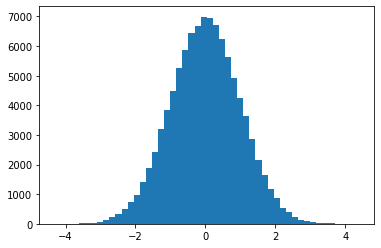

In [169]:
plt.hist(values,bins=50)
plt.show()